# Explain an Intermediate Layer of VGG16 on ImageNet

Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the 7th layer of the pretrained VGG16 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

In [2]:
!pip3 install shap

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
import keras.backend as K
import json

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

    100% |████████████████████████████████| 235kB 4.5MB/s eta 0:00:01
    100% |████████████████████████████████| 26.2MB 73kB/s  eta 0:00:011
    100% |████████████████████████████████| 4.4MB 463kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.8MB 1.2MB/s  eta 0:00:01
  Running setup.py bdist_wheel for shap ... done
  Stored in directory: /root/.cache/pip/wheels/93/3f/4a/331cf71b5043416aeba0df795e7c204c7ad277673f1938d11b
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built shap networkx
You are using pip version 8.1.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


553467904/553467096 [==============================] - 47s 0us/step


<Figure size 900x750 with 7 Axes>

## Explain with local smoothing

Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

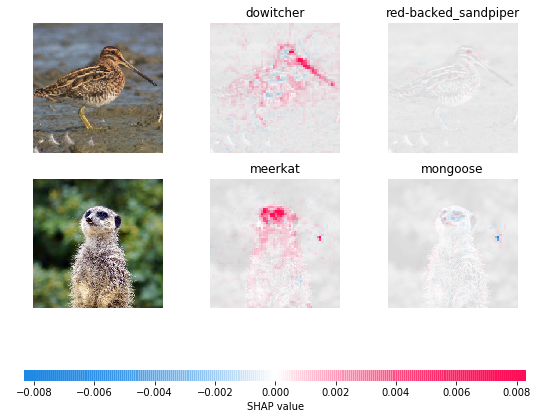

In [3]:
# explain how the input to the 7th layer of the model explains the top two classes
explainer = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), 7),
    local_smoothing=100
)
shap_values,indexes = explainer.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)